## Installing offline deps

As this is a code comp, there is no internet. 
So we have to do some silly things to get dependencies in here. 
Why is asciitree such a PITA? 

In [29]:
deps_path = '/kaggle/input/czii-cryoet-dependencies'

In [30]:
! cp -r /kaggle/input/czii-cryoet-dependencies/asciitree-0.3.3/ asciitree-0.3.3/

In [31]:
! pip wheel asciitree-0.3.3/asciitree-0.3.3/

Processing ./asciitree-0.3.3/asciitree-0.3.3
  Preparing metadata (setup.py) ... done
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5034 sha256=bfb9705e63ac059f872a7030c9c232d6aa56be7b55fb8cd2fd903d4b3435fc07
  Stored in directory: /root/.cache/pip/wheels/77/df/a8/c6318c87827b53ea48635bf95b1249186d3d21f041176e062e
Successfully built asciitree


In [32]:
!pip install asciitree-0.3.3-py3-none-any.whl

Processing ./asciitree-0.3.3-py3-none-any.whl
asciitree is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [33]:
! pip install -q --no-index --find-links {deps_path} --requirement {deps_path}/requirements.txt

In [34]:
from typing import List, Tuple, Union
import numpy as np
import torch
from monai.data import DataLoader, Dataset, CacheDataset, decollate_batch
from monai.transforms import (
    Compose, 
    EnsureChannelFirstd, 
    Orientationd,  
    AsDiscrete,  
    RandFlipd, 
    RandRotate90d, 
    NormalizeIntensityd,
    RandCropByLabelClassesd,
)

## Define some helper functions


### Patching helper functions

These are mostly used to split large volumes into smaller ones and stitch them back together. 

In [35]:
def calculate_patch_starts(dimension_size: int, patch_size: int) -> List[int]:
    """
    Calculate the starting positions of patches along a single dimension
    with minimal overlap to cover the entire dimension.
    
    Parameters:
    -----------
    dimension_size : int
        Size of the dimension
    patch_size : int
        Size of the patch in this dimension
        
    Returns:
    --------
    List[int]
        List of starting positions for patches
    """
    if dimension_size <= patch_size:
        return [0]
        
    # Calculate number of patches needed
    n_patches = np.ceil(dimension_size / patch_size)
    
    if n_patches == 1:
        return [0]
    
    # Calculate overlap
    total_overlap = (n_patches * patch_size - dimension_size) / (n_patches - 1)
    
    # Generate starting positions
    positions = []
    for i in range(int(n_patches)):
        pos = int(i * (patch_size - total_overlap))
        if pos + patch_size > dimension_size:
            pos = dimension_size - patch_size
        if pos not in positions:  # Avoid duplicates
            positions.append(pos)
    
    return positions

def extract_3d_patches_minimal_overlap(arrays: List[np.ndarray], patch_size: int) -> Tuple[List[np.ndarray], List[Tuple[int, int, int]]]:
    """
    Extract 3D patches from multiple arrays with minimal overlap to cover the entire array.
    
    Parameters:
    -----------
    arrays : List[np.ndarray]
        List of input arrays, each with shape (m, n, l)
    patch_size : int
        Size of cubic patches (a x a x a)
        
    Returns:
    --------
    patches : List[np.ndarray]
        List of all patches from all input arrays
    coordinates : List[Tuple[int, int, int]]
        List of starting coordinates (x, y, z) for each patch
    """
    if not arrays or not isinstance(arrays, list):
        raise ValueError("Input must be a non-empty list of arrays")
    
    # Verify all arrays have the same shape
    shape = arrays[0].shape
    if not all(arr.shape == shape for arr in arrays):
        raise ValueError("All input arrays must have the same shape")
    
    if patch_size > min(shape):
        raise ValueError(f"patch_size ({patch_size}) must be smaller than smallest dimension {min(shape)}")
    
    m, n, l = shape
    patches = []
    coordinates = []
    
    # Calculate starting positions for each dimension
    x_starts = calculate_patch_starts(m, patch_size)
    y_starts = calculate_patch_starts(n, patch_size)
    z_starts = calculate_patch_starts(l, patch_size)
    
    # Extract patches from each array
    for arr in arrays:
        for x in x_starts:
            for y in y_starts:
                for z in z_starts:
                    patch = arr[
                        x:x + patch_size,
                        y:y + patch_size,
                        z:z + patch_size
                    ]
                    patches.append(patch)
                    coordinates.append((x, y, z))
    
    return patches, coordinates

# Note: I should probably averge the overlapping areas, 
# but here they are just overwritten by the most recent one. 

def reconstruct_array(patches: List[np.ndarray], 
                     coordinates: List[Tuple[int, int, int]], 
                     original_shape: Tuple[int, int, int]) -> np.ndarray:
    """
    Reconstruct array from patches.
    
    Parameters:
    -----------
    patches : List[np.ndarray]
        List of patches to reconstruct from
    coordinates : List[Tuple[int, int, int]]
        Starting coordinates for each patch
    original_shape : Tuple[int, int, int]
        Shape of the original array
        
    Returns:
    --------
    np.ndarray
        Reconstructed array
    """
    reconstructed = np.zeros(original_shape, dtype=np.int64)  # To track overlapping regions
    
    patch_size = patches[0].shape[0]
    
    for patch, (x, y, z) in zip(patches, coordinates):
        reconstructed[
            x:x + patch_size,
            y:y + patch_size,
            z:z + patch_size
        ] = patch
        
    
    return reconstructed

## Submission helper functions

These help with getting the submission in the correct format

In [36]:
import pandas as pd

def dict_to_df(coord_dict, experiment_name):
    """
    Convert dictionary of coordinates to pandas DataFrame.
    
    Parameters:
    -----------
    coord_dict : dict
        Dictionary where keys are labels and values are Nx3 coordinate arrays
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with columns ['x', 'y', 'z', 'label']
    """
    # Create lists to store data
    all_coords = []
    all_labels = []
    
    # Process each label and its coordinates
    for label, coords in coord_dict.items():
        all_coords.append(coords)
        all_labels.extend([label] * len(coords))
    
    # Concatenate all coordinates
    all_coords = np.vstack(all_coords)
    
    df = pd.DataFrame({
        'experiment': experiment_name,
        'particle_type': all_labels,
        'x': all_coords[:, 0],
        'y': all_coords[:, 1],
        'z': all_coords[:, 2]
    })

    
    return df

## Reading in the data

In [37]:
TRAIN_DATA_DIR = "/kaggle/input/create-numpy-dataset-exp-name"
TEST_DATA_DIR = "/kaggle/input/czii-cryo-et-object-identification"

In [38]:
train_names = ['TS_5_4', 'TS_69_2', 'TS_6_6', 'TS_73_6', 'TS_86_3', 'TS_99_9']
valid_names = ['TS_6_4']

train_files = []
valid_files = []

for name in train_names:
    image = np.load(f"{TRAIN_DATA_DIR}/train_image_{name}.npy")
    label = np.load(f"{TRAIN_DATA_DIR}/train_label_{name}.npy")

    train_files.append({"image": image, "label": label})
    

for name in valid_names:
    image = np.load(f"{TRAIN_DATA_DIR}/train_image_{name}.npy")
    label = np.load(f"{TRAIN_DATA_DIR}/train_label_{name}.npy")

    valid_files.append({"image": image, "label": label})

### Create the training dataloader

I should probably find a way to create a dataloader that takes more batches. 

In [39]:
# Non-random transforms to be cached
non_random_transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    Orientationd(keys=["image", "label"], axcodes="RAS")
])

raw_train_ds = CacheDataset(data=train_files, transform=non_random_transforms, cache_rate=1.0)


my_num_samples = 16
train_batch_size = 1

# Random transforms to be applied during training
random_transforms = Compose([
    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[96, 96, 96],
        num_classes=7,
        num_samples=my_num_samples
    ),
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[0, 2]),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),    
])

train_ds = Dataset(data=raw_train_ds, transform=random_transforms)


# DataLoader remains the same
train_loader = DataLoader(
    train_ds,
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=torch.cuda.is_available()
)

Loading dataset: 100%|██████████| 6/6 [00:02<00:00,  2.53it/s]


### Create the validation dataloader

Here I deviate a little from the source notebooks. 

In the source, the validation dataloader also used the random transformations. This is bad practice and will result in noisy validation. 

Here I split the validation dataset in (slightly) overlapping blocks of `(96, 96 , 96)` so that we can have a consistent validation set that uses all the validation data. 


In [40]:
val_images,val_labels = [dcts['image'] for dcts in valid_files],[dcts['label'] for dcts in valid_files]

val_image_patches, _ = extract_3d_patches_minimal_overlap(val_images, 96)
val_label_patches, _ = extract_3d_patches_minimal_overlap(val_labels, 96)

val_patched_data = [{"image": img, "label": lbl} for img, lbl in zip(val_image_patches, val_label_patches)]


valid_ds = CacheDataset(data=val_patched_data, transform=non_random_transforms, cache_rate=1.0)


valid_batch_size = 16
# DataLoader remains the same
valid_loader = DataLoader(
    valid_ds,
    batch_size=valid_batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=torch.cuda.is_available()
)

Loading dataset: 100%|██████████| 98/98 [00:00<00:00, 130.70it/s]


## Create Synthetic DataLoader

In [41]:
!pip install /kaggle/input/mrclib/mrcfile-1.5.3-py2.py3-none-any.whl

Processing /kaggle/input/mrclib/mrcfile-1.5.3-py2.py3-none-any.whl
mrcfile is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [44]:
import mrcfile
import numpy as np

# Directory containing the .mrc files
SYNTHETIC_DIR = "/kaggle/input/syntheticts-0andnotations"

# File names
tomogram_file = f"{SYNTHETIC_DIR}/TS_0.mrc"
segmentation_files = [
    "cytosolic_ribosome-1.0_segmentationmask.mrc",
    "beta_galactosidase-1.0_segmentationmask.mrc",
    "beta_amylase-1.0_segmentationmask.mrc",
    "ferritin_complex-1.0_segmentationmask.mrc",
    "membrane-1.0_segmentationmask.mrc",
    "pp7_vlp-1.0_segmentationmask.mrc",
    "thyroglobulin-1.0_segmentationmask.mrc",
]

# List to hold the processed data
synthetic_files = []

# Load the tomogram
with mrcfile.open(tomogram_file, permissive=True) as mrc:
    tomogram = mrc.data.astype(np.float32)  # Convert to float32 if needed

# Process each segmentation mask and create the dictionary structure
for seg_file in segmentation_files:
    seg_path = f"{SYNTHETIC_DIR}/{seg_file}"
    with mrcfile.open(seg_path, permissive=True) as mrc:
        label = mrc.data.astype(np.uint8)  # Convert to uint8 for labels
    
    # Append the image-label pair as a dictionary
    synthetic_files.append({"image": tomogram, "label": label})

In [45]:
# Non-random transforms to be cached
non_random_transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    Orientationd(keys=["image", "label"], axcodes="RAS")
])

raw_synthetic_ds = CacheDataset(data=synthetic_files, transform=non_random_transforms, cache_rate=1.0)


my_num_samples = 16
synthetic_batch_size = 1

# Random transforms to be applied during training
random_transforms = Compose([
    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[96, 96, 96],
        num_classes=7,
        num_samples=my_num_samples
    ),
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[0, 2]),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),    
])

synthetic_ds = Dataset(data=raw_synthetic_ds, transform=random_transforms)


# DataLoader remains the same
synthetic_loader = DataLoader(
    synthetic_ds,
    batch_size=synthetic_batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=torch.cuda.is_available()
)

Loading dataset: 100%|██████████| 7/7 [00:02<00:00,  2.45it/s]


## Initialize the model

This model is pretty much directly copied from [3D U-Net PyTorch Lightning distributed training](https://www.kaggle.com/code/zhuowenzhao11/3d-u-net-pytorch-lightning-distributed-training)

In [46]:
import torch
import torch.nn as nn
from typing import Sequence, Union
from monai.networks.blocks.convolutions import Convolution, ResidualUnit
from monai.networks.layers.simplelayers import SkipConnection

class UNet(nn.Module):
    """
    UNet implementation with residual units.

    Args:
        spatial_dims: Number of spatial dimensions.
        in_channels: Number of input channels.
        out_channels: Number of output channels.
        channels: Sequence of channels. Top block first. Must have at least 2 elements.
        strides: Sequence of convolution strides. Length must be `len(channels) - 1`.
        kernel_size: Convolution kernel size (odd values only). Defaults to 3.
        up_kernel_size: Upsampling convolution kernel size (odd values only). Defaults to 3.
        num_res_units: Number of residual units. Defaults to 0.
        act: Activation type. Defaults to PReLU.
        norm: Normalization type. Defaults to instance norm.
        dropout: Dropout ratio. Defaults to 0.0.
        bias: Whether to include bias in convolution layers. Defaults to True.
        adn_ordering: Ordering of activation (A), normalization (N), and dropout (D). Defaults to "NDA".
    """

    def __init__(
        self,
        spatial_dims: int,
        in_channels: int,
        out_channels: int,
        channels: Sequence[int],
        strides: Sequence[int],
        kernel_size: Union[Sequence[int], int] = 3,
        up_kernel_size: Union[Sequence[int], int] = 3,
        num_res_units: int = 0,
        act: Union[str, tuple] = "PRELU",
        norm: Union[str, tuple] = "INSTANCE",
        dropout: float = 0.0,
        bias: bool = True,
        adn_ordering: str = "NDA",
    ) -> None:
        super().__init__()

        if len(channels) < 2:
            raise ValueError("`channels` must have at least 2 elements.")
        if len(strides) != len(channels) - 1:
            raise ValueError("`strides` length must be `len(channels) - 1`.")

        self.dimensions = spatial_dims
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.channels = channels
        self.strides = strides
        self.kernel_size = kernel_size
        self.up_kernel_size = up_kernel_size
        self.num_res_units = num_res_units
        self.act = act
        self.norm = norm
        self.dropout = dropout
        self.bias = bias
        self.adn_ordering = adn_ordering

        def _create_block(inc, outc, channels, strides, is_top):
            c = channels[0]
            s = strides[0]

            if len(channels) > 2:
                subblock = _create_block(c, c, channels[1:], strides[1:], False)
                upc = c * 2
            else:
                subblock = self._get_bottom_layer(c, channels[1])
                upc = c + channels[1]

            down = self._get_down_layer(inc, c, s, is_top)
            up = self._get_up_layer(upc, outc, s, is_top)

            return self._get_connection_block(down, up, subblock)

        self.model = _create_block(in_channels, out_channels, self.channels, self.strides, True)

    def _get_connection_block(self, down_path, up_path, subblock):
        return nn.Sequential(down_path, SkipConnection(subblock), up_path)

    def _get_down_layer(self, in_channels, out_channels, strides, is_top):
        if self.num_res_units > 0:
            return ResidualUnit(
                self.dimensions, in_channels, out_channels, strides=strides,
                kernel_size=self.kernel_size, subunits=self.num_res_units,
                act=self.act, norm=self.norm, dropout=self.dropout, bias=self.bias,
                adn_ordering=self.adn_ordering,
            )
        return Convolution(
            self.dimensions, in_channels, out_channels, strides=strides,
            kernel_size=self.kernel_size, act=self.act, norm=self.norm,
            dropout=self.dropout, bias=self.bias, adn_ordering=self.adn_ordering,
        )

    def _get_bottom_layer(self, in_channels, out_channels):
        return self._get_down_layer(in_channels, out_channels, 1, False)

    def _get_up_layer(self, in_channels, out_channels, strides, is_top):
        conv = Convolution(
            self.dimensions, in_channels, out_channels, strides=strides,
            kernel_size=self.up_kernel_size, act=self.act, norm=self.norm,
            dropout=self.dropout, bias=self.bias, conv_only=is_top and self.num_res_units == 0,
            is_transposed=True, adn_ordering=self.adn_ordering,
        )

        if self.num_res_units > 0:
            ru = ResidualUnit(
                self.dimensions, out_channels, out_channels, strides=1,
                kernel_size=self.kernel_size, subunits=1, act=self.act, norm=self.norm,
                dropout=self.dropout, bias=self.bias, last_conv_only=is_top,
                adn_ordering=self.adn_ordering,
            )
            conv = nn.Sequential(conv, ru)

        return conv

    def forward(self, x):
        return self.model(x)

In [47]:
import lightning.pytorch as pl

#from monai.networks.nets import UNet
from monai.losses import TverskyLoss
from monai.metrics import DiceMetric

class Model(pl.LightningModule):
    def __init__(
        self, 
        spatial_dims: int = 3,
        in_channels: int = 1,
        out_channels: int = 7,
        channels: Union[Tuple[int, ...], List[int]] = (48, 64, 80, 80),
        strides: Union[Tuple[int, ...], List[int]] = (2, 2, 1),
        num_res_units: int = 1,
        lr: float=1e-3):
    
        super().__init__()
        self.save_hyperparameters()
        self.model = UNet(
            spatial_dims=self.hparams.spatial_dims,
            in_channels=self.hparams.in_channels,
            out_channels=self.hparams.out_channels,
            channels=self.hparams.channels,
            strides=self.hparams.strides,
            num_res_units=self.hparams.num_res_units
        )
        self.loss_fn = TverskyLoss(include_background=True, to_onehot_y=True, softmax=True)  # softmax=True for multiclass
        self.metric_fn = DiceMetric(include_background=False, reduction="mean", ignore_empty=True)

        self.train_loss = 0
        self.val_metric = 0
        self.num_train_batch = 0
        self.num_val_batch = 0

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch['image'], batch['label']
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.train_loss += loss
        self.num_train_batch += 1
        torch.cuda.empty_cache()
        return loss

    def on_train_epoch_end(self):
        loss_per_epoch = self.train_loss/self.num_train_batch
        #print(f"Epoch {self.current_epoch} - Average Train Loss: {loss_per_epoch:.4f}")
        self.log('train_loss', loss_per_epoch, prog_bar=True)
        self.train_loss = 0
        self.num_train_batch = 0
    
    def validation_step(self, batch, batch_idx):
        with torch.no_grad(): # This ensures that gradients are not stored in memory
            x, y = batch['image'], batch['label']
            y_hat = self(x)
            metric_val_outputs = [AsDiscrete(argmax=True, to_onehot=self.hparams.out_channels)(i) for i in decollate_batch(y_hat)]
            metric_val_labels = [AsDiscrete(to_onehot=self.hparams.out_channels)(i) for i in decollate_batch(y)]

            # compute metric for current iteration
            self.metric_fn(y_pred=metric_val_outputs, y=metric_val_labels)
            metrics = self.metric_fn.aggregate(reduction="mean_batch")
            val_metric = torch.mean(metrics) # I used mean over all particle species as the metric. This can be explored.
            self.val_metric += val_metric 
            self.num_val_batch += 1
        torch.cuda.empty_cache()
        return {'val_metric': val_metric}

    def on_validation_epoch_end(self):
        metric_per_epoch = self.val_metric/self.num_val_batch
        #print(f"Epoch {self.current_epoch} - Average Val Metric: {metric_per_epoch:.4f}")
        self.log('val_metric', metric_per_epoch, prog_bar=True, sync_dist=False) # sync_dist=True for distributed training
        self.val_metric = 0
        self.num_val_batch = 0
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)

In [48]:
channels = (48, 64, 80, 80)
strides_pattern = (2, 2, 1)       
num_res_units = 1
learning_rate = 1e-3
num_epochs = 100

model = Model(channels=channels, strides=strides_pattern, num_res_units=num_res_units, lr=learning_rate)
print('Model Ready!')

Model Ready!


### different depths

In [ ]:
#from itertools import combinations

#base_channels = [32, 48, 64, 80, 96]
#possible_depths = [3, 4, 5]  # Number of layers to test

# Iterate over different depths
#for depth in possible_depths:
#    current_channels = base_channels[:depth]
#    current_strides = [2] * (depth - 1)  # Use a uniform stride pattern
#    model = Model(channels=current_channels, strides=current_strides, num_res_units=1, lr=1e-3)
#    print(f"Testing Model with Depth {depth} - Channels: {current_channels}")
    # Train and evaluate the model here


## Pre-train with Synthetic data

In [49]:
from lightning.pytorch.callbacks import EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger
import torch
import lightning.pytorch as pl

torch.set_float32_matmul_precision('medium')

# Initialize the logger
prelogger = TensorBoardLogger(
    save_dir="/kaggle/working/logs",       # Root directory to save logs
    name="pretrain",        # Subdirectory name for this experiment
    log_graph=True         # Optional: Log the computational graph
)

# Check if CUDA is available and then count the GPUs
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")
    devices = list(range(num_gpus))
    print(devices)

    pretrainer = pl.Trainer(
        max_epochs=100,
        logger=prelogger,
        #strategy="ddp_notebook", 
        accelerator="gpu",
        devices=[0],# devices
        num_nodes=1,
        log_every_n_steps=10,
        enable_progress_bar=True,
    )
else:
    print("No GPU available. Running on CPU.")
    pretrainer = pl.Trainer(
        max_epochs=5,
        logger=prelogger,
        #strategy="ddp_notebook", 
        accelerator="cpu",
        num_nodes=1,
        log_every_n_steps=10,
        enable_progress_bar=True,
    )
pretrainer.fit(model, synthetic_loader)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


Number of GPUs available: 1
[0]


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type        | Params | Mode 
------------------------------------------------
0 | model   | UNet        | 1.1 M  | train
1 | loss_fn | TverskyLoss | 0      | train
------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.480     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loggers/tensorboard.py:191: Could not log computational graph to TensorBoard: The `model.example_input_array` attribute is not set or `input_array` was not given.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (7) is smaller

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 3 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 2 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 4 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/monai/transforms/utils.py:743: UserWarning: no available indices of class 3 to crop, setting the crop ratio of this class to zero.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/monai/transforms/uti

In [50]:
import torch
#
save_path = "/kaggle/working/pretrained_synthetic_weights.pth"
#
# Save the model's state_dict
torch.save(model.state_dict(), save_path)
#
print(f"Model weights saved to {save_path}")

Model weights saved to /kaggle/working/pretrained_synthetic_weights.pth


## Train the model



In [ ]:
#model.load_state_dict(torch.load("/kaggle/input/weights/pretrained_synthetic_weights.pth"))

In [52]:
# Check if CUDA is available and configure the trainer
torch.set_float32_matmul_precision('medium')

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor="val_metric",  # Metric to monitor
    mode="max",            # "max" because higher Dice is better
    patience=10,           # Stop if no improvement after 10 epochs
    verbose=True
)

# Initialize the logger
logger = TensorBoardLogger(
    save_dir="/kaggle/working/logs",       # Root directory to save logs
    name="model",        # Subdirectory name for this experiment
    log_graph=True         # Optional: Log the computational graph
)

if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")
    devices = list(range(num_gpus))
    print(f"Using GPU devices: {devices}")

    trainer = pl.Trainer(
        max_epochs=100,
        logger=logger,
        accelerator="gpu",
        devices=[0],  # Specify the GPU to use (modify if needed)
        num_nodes=1,
        log_every_n_steps=1,
        enable_progress_bar=True,
        callbacks=[early_stopping],  # Add EarlyStopping callback here
    )
else:
    print("No GPU available. Running on CPU.")

    trainer = pl.Trainer(
        max_epochs=10,
        logger=logger,
        accelerator="cpu",
        num_nodes=1,
        log_every_n_steps=1,
        enable_progress_bar=True,
        callbacks=[early_stopping],  # Add EarlyStopping callback here
    )

# Start training
print("Training started...")
#model.load_state_dict(torch.load("/kaggle/working/pretrained_model_5_weights.pth", weights_only=True))
trainer.fit(model, train_loader, valid_loader)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name    | Type        | Params | Mode 
------------------------------------------------
0 | model   | UNet        | 1.1 M  | train
1 | loss_fn | TverskyLoss | 0      | train
------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.480     Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Number of GPUs available: 1
Using GPU devices: [0]
Training started...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved. New best score: 0.006


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.001 >= min_delta = 0.0. New best score: 0.007


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.005 >= min_delta = 0.0. New best score: 0.012


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.011 >= min_delta = 0.0. New best score: 0.023


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.010 >= min_delta = 0.0. New best score: 0.034


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.008 >= min_delta = 0.0. New best score: 0.042


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.008 >= min_delta = 0.0. New best score: 0.050


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.007 >= min_delta = 0.0. New best score: 0.056


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.007 >= min_delta = 0.0. New best score: 0.063


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.007 >= min_delta = 0.0. New best score: 0.070


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.007 >= min_delta = 0.0. New best score: 0.077


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.007 >= min_delta = 0.0. New best score: 0.084


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.007 >= min_delta = 0.0. New best score: 0.092


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.007 >= min_delta = 0.0. New best score: 0.099


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.007 >= min_delta = 0.0. New best score: 0.106


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.006 >= min_delta = 0.0. New best score: 0.112


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.007 >= min_delta = 0.0. New best score: 0.119


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.006 >= min_delta = 0.0. New best score: 0.125


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.005 >= min_delta = 0.0. New best score: 0.130


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.004 >= min_delta = 0.0. New best score: 0.134


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.005 >= min_delta = 0.0. New best score: 0.139


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.005 >= min_delta = 0.0. New best score: 0.143


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.004 >= min_delta = 0.0. New best score: 0.148


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.005 >= min_delta = 0.0. New best score: 0.153


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.005 >= min_delta = 0.0. New best score: 0.158


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.005 >= min_delta = 0.0. New best score: 0.162


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.005 >= min_delta = 0.0. New best score: 0.167


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.005 >= min_delta = 0.0. New best score: 0.172


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.005 >= min_delta = 0.0. New best score: 0.177


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.005 >= min_delta = 0.0. New best score: 0.182


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.004 >= min_delta = 0.0. New best score: 0.186


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.004 >= min_delta = 0.0. New best score: 0.190


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.004 >= min_delta = 0.0. New best score: 0.194


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.005 >= min_delta = 0.0. New best score: 0.199


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.004 >= min_delta = 0.0. New best score: 0.203


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.004 >= min_delta = 0.0. New best score: 0.207


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.003 >= min_delta = 0.0. New best score: 0.210


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.003 >= min_delta = 0.0. New best score: 0.214


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.003 >= min_delta = 0.0. New best score: 0.217


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.003 >= min_delta = 0.0. New best score: 0.220


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.003 >= min_delta = 0.0. New best score: 0.223


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.003 >= min_delta = 0.0. New best score: 0.226


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.003 >= min_delta = 0.0. New best score: 0.229


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.003 >= min_delta = 0.0. New best score: 0.232


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.003 >= min_delta = 0.0. New best score: 0.236


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.003 >= min_delta = 0.0. New best score: 0.239


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.003 >= min_delta = 0.0. New best score: 0.242


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.003 >= min_delta = 0.0. New best score: 0.245


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.003 >= min_delta = 0.0. New best score: 0.248


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.003 >= min_delta = 0.0. New best score: 0.250


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.003 >= min_delta = 0.0. New best score: 0.253


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.003 >= min_delta = 0.0. New best score: 0.256


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.002 >= min_delta = 0.0. New best score: 0.258


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.002 >= min_delta = 0.0. New best score: 0.261


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.002 >= min_delta = 0.0. New best score: 0.263


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.002 >= min_delta = 0.0. New best score: 0.265


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.002 >= min_delta = 0.0. New best score: 0.268


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.002 >= min_delta = 0.0. New best score: 0.270


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.003 >= min_delta = 0.0. New best score: 0.272


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.002 >= min_delta = 0.0. New best score: 0.275


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.002 >= min_delta = 0.0. New best score: 0.277


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.002 >= min_delta = 0.0. New best score: 0.279


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.002 >= min_delta = 0.0. New best score: 0.281


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.002 >= min_delta = 0.0. New best score: 0.282


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.002 >= min_delta = 0.0. New best score: 0.284


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.002 >= min_delta = 0.0. New best score: 0.286


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.002 >= min_delta = 0.0. New best score: 0.287


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.002 >= min_delta = 0.0. New best score: 0.289


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.002 >= min_delta = 0.0. New best score: 0.291


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.002 >= min_delta = 0.0. New best score: 0.293


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.002 >= min_delta = 0.0. New best score: 0.294


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.002 >= min_delta = 0.0. New best score: 0.296


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.001 >= min_delta = 0.0. New best score: 0.297


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.001 >= min_delta = 0.0. New best score: 0.299


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.001 >= min_delta = 0.0. New best score: 0.300


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.002 >= min_delta = 0.0. New best score: 0.302


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.002 >= min_delta = 0.0. New best score: 0.303


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.001 >= min_delta = 0.0. New best score: 0.305


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.001 >= min_delta = 0.0. New best score: 0.306


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.001 >= min_delta = 0.0. New best score: 0.307


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.001 >= min_delta = 0.0. New best score: 0.309


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.001 >= min_delta = 0.0. New best score: 0.310


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.001 >= min_delta = 0.0. New best score: 0.311


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.001 >= min_delta = 0.0. New best score: 0.313


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.001 >= min_delta = 0.0. New best score: 0.314


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.001 >= min_delta = 0.0. New best score: 0.315


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.001 >= min_delta = 0.0. New best score: 0.316


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.001 >= min_delta = 0.0. New best score: 0.317


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.001 >= min_delta = 0.0. New best score: 0.318


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.001 >= min_delta = 0.0. New best score: 0.319


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.001 >= min_delta = 0.0. New best score: 0.320


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.001 >= min_delta = 0.0. New best score: 0.322


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.001 >= min_delta = 0.0. New best score: 0.323


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.001 >= min_delta = 0.0. New best score: 0.324


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.001 >= min_delta = 0.0. New best score: 0.325


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.001 >= min_delta = 0.0. New best score: 0.326


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.001 >= min_delta = 0.0. New best score: 0.327


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.001 >= min_delta = 0.0. New best score: 0.328


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.001 >= min_delta = 0.0. New best score: 0.329


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_metric improved by 0.001 >= min_delta = 0.0. New best score: 0.330
INFO: `Trainer.fit` stopped: `max_epochs=100` reached.


## Visualization

In [53]:
import os
import glob
import json
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def extract_logs(log_dir):
    """
    Extracts scalar metrics from TensorBoard event files in the specified directory.
    Args:
        log_dir (str): Path to the log directory.
    Returns:
        dict: A dictionary containing metric names as keys and their epoch-value pairs as lists.
    """
    logs = {}
    try:
        # Locate the event file
        event_file = [
            file for file in os.listdir(log_dir) if file.startswith("events.out")
        ][0]
        event_path = os.path.join(log_dir, event_file)
        
        # Use EventAccumulator to process the event file
        event_acc = EventAccumulator(event_path)
        event_acc.Reload()

        # Extract scalar metrics
        for tag in event_acc.Tags()["scalars"]:
            logs[tag] = [
                (scalar.step, scalar.value)
                for scalar in event_acc.Scalars(tag)
            ]
    except Exception as e:
        print(f"Failed to extract logs from {log_dir}: {e}")
    return logs

# Extract specific metrics
def get_metric_from_logs(logs, metric_name):
    """
    Retrieve a specific metric from logs.
    Args:
        logs (dict): Logs extracted with `extract_logs`.
        metric_name (str): Name of the metric to retrieve.
    Returns:
        list: A list of values for the metric.
    """
    if metric_name in logs:
        # Extract only the values from the (step, value) tuples
        return [value for _, value in logs[metric_name]]
    else:
        print(f"Metric '{metric_name}' not found in logs.")
        return []

# Directories of the log files
log_dir = "/kaggle/working/logs/model/version_0"

# Extract logs for all experiments
logs = extract_logs(log_dir)

# Training and validation metrics for each experiment
train_loss = get_metric_from_logs(logs, "train_loss")
val_metric = get_metric_from_logs(logs, "val_metric")

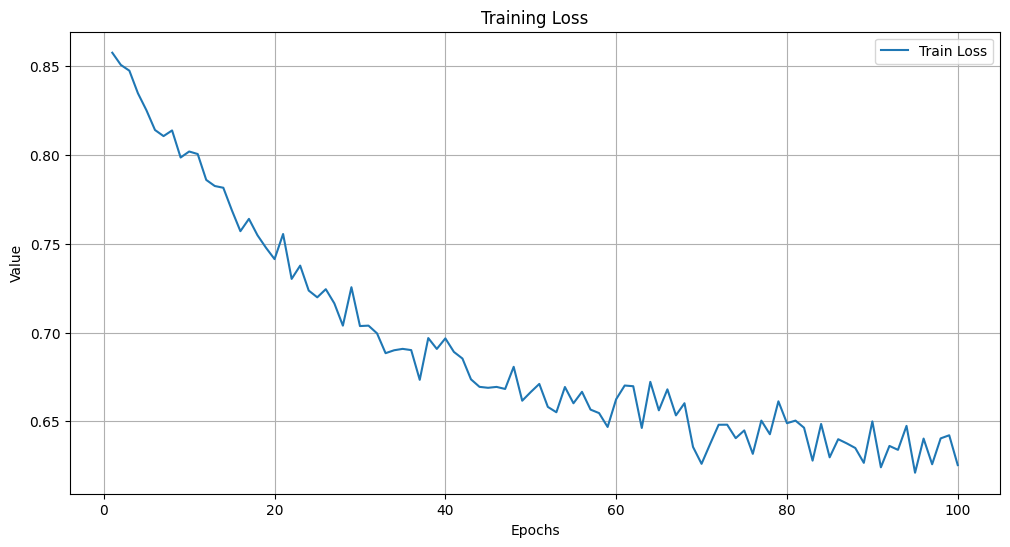

In [54]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_loss) + 1)

# Create the plot
plt.figure(figsize=(12, 6))

# Customize plot
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.plot(epochs, train_loss, label="Train Loss")
plt.title("Training Loss")
plt.legend(loc="upper right")
plt.grid()

# Show the plot
plt.show()

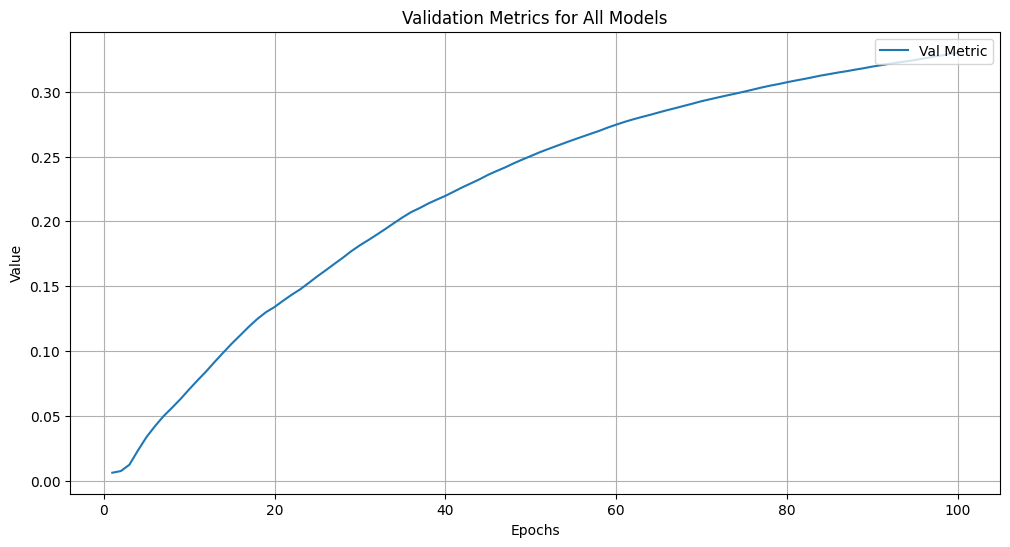

In [55]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_loss) + 1)

# Create the plot
plt.figure(figsize=(12, 6))

# Customize plot
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.plot(epochs, val_metric, label="Val Metric")
plt.title("Validation Metrics for All Models")
plt.legend(loc="upper right")
plt.grid()

# Show the plot
plt.show()

## Predict on the test set



In [56]:
model.eval();
model.to("cuda");

In [57]:
import json
copick_config_path = TRAIN_DATA_DIR + "/copick.config"

with open(copick_config_path) as f:
    copick_config = json.load(f)

copick_config['static_root'] = '/kaggle/input/czii-cryo-et-object-identification/test/static'

copick_test_config_path = 'copick_test.config'

with open(copick_test_config_path, 'w') as outfile:
    json.dump(copick_config, outfile)

import copick

root = copick.from_file(copick_test_config_path)

copick_user_name = "copickUtils"
copick_segmentation_name = "paintedPicks"
voxel_size = 10
tomo_type = "denoised"

# Non-random transforms to be cached
inference_transforms = Compose([
    EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    Orientationd(keys=["image"], axcodes="RAS")
])

import cc3d

id_to_name = {1: "apo-ferritin", 
              2: "beta-amylase",
              3: "beta-galactosidase", 
              4: "ribosome", 
              5: "thyroglobulin", 
              6: "virus-like-particle"}

<ipython-input-57-39e39b20d41a>:16: DeprecationWarning: config_type not found in config file, defaulting to filesystem
  root = copick.from_file(copick_test_config_path)


In [59]:
BLOB_THRESHOLD = 500
CERTAINTY_THRESHOLD = 0.5

classes = [1, 2, 3, 4, 5, 6]
with torch.no_grad():
    location_df = []
    for run in root.runs:
        print(run)

        tomo = run.get_voxel_spacing(10)
        tomo = tomo.get_tomogram(tomo_type).numpy()



        tomo_patches, coordinates  = extract_3d_patches_minimal_overlap([tomo], 96)

        tomo_patched_data = [{"image": img} for img in tomo_patches]

        tomo_ds = CacheDataset(data=tomo_patched_data, transform=inference_transforms, cache_rate=1.0)

        pred_masks = []

        for i in range(len(tomo_ds)):
            input_tensor = tomo_ds[i]['image'].unsqueeze(0).to("cuda")
            model_output = model(input_tensor)

            probs = torch.softmax(model_output[0], dim=0)
            thresh_probs = probs > CERTAINTY_THRESHOLD
            _, max_classes = thresh_probs.max(dim=0)

            pred_masks.append(max_classes.cpu().numpy())
            
        reconstructed_mask = reconstruct_array(pred_masks, coordinates, tomo.shape)
        
        location = {}

        for c in classes:
            cc = cc3d.connected_components(reconstructed_mask == c)
            stats = cc3d.statistics(cc)
            zyx=stats['centroids'][1:]*10.012444 #https://www.kaggle.com/competitions/czii-cryo-et-object-identification/discussion/544895#3040071
            zyx_large = zyx[stats['voxel_counts'][1:] > BLOB_THRESHOLD]
            xyz =np.ascontiguousarray(zyx_large[:,::-1])

            location[id_to_name[c]] = xyz


        df = dict_to_df(location, run.name)
        location_df.append(df)
    
    location_df = pd.concat(location_df)

CopickRun(name=TS_5_4, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7ab5fe937e50


Loading dataset: 100%|██████████| 98/98 [00:00<00:00, 158.45it/s]


CopickRun(name=TS_69_2, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7ab694ff14b0


Loading dataset: 100%|██████████| 98/98 [00:00<00:00, 151.84it/s]


CopickRun(name=TS_6_4, len(voxel_spacings)=None, len(picks)=None, len(meshes)=None, len(segmentations)=None) at 0x7ab6012d65c0


Loading dataset: 100%|██████████| 98/98 [00:00<00:00, 157.62it/s]


In [61]:
location_df.insert(loc=0, column='id', value=np.arange(len(location_df)))
location_df.to_csv("submission.csv", index=False)

ValueError: cannot insert id, already exists

In [62]:
!cp -r /kaggle/input/hengck-czii-cryo-et-01/* .

['TS_5_4', 'TS_69_2', 'TS_6_4']
 TS_6_4 virus-like-particlee
         particle_type    P    T  hit  miss   fp  precision    recall  \
0         apo-ferritin   66  139   51    88   15   0.772727  0.366906   
1         beta-amylase   98   31   18    13   80   0.183673  0.580645   
2   beta-galactosidase  157   40   22    18  135   0.140127  0.550000   
3             ribosome  290  142  106    36  184   0.365517  0.746479   
4        thyroglobulin  560   94   83    11  477   0.148214  0.882979   
5  virus-like-particle   96   30   28     2   68   0.291667  0.933333   

    f-beta4  weight  
0  0.378603       1  
1  0.515152       0  
2  0.469260       2  
3  0.703357       1  
4  0.683624       2  
5  0.826389       1  
lb_score: 0.6020165387797923

TS_6_4 apo-ferritin
	 num truth   : 58
	 num predict : 26
	 num hit  : 22
	 num fp   : 4
	 num miss : 36
TS_6_4 beta-amylase
	 num truth   : 9
	 num predict : 33
	 num hit  : 7
	 num fp   : 26
	 num miss : 2
TS_6_4 beta-galactosidase
	 num tru

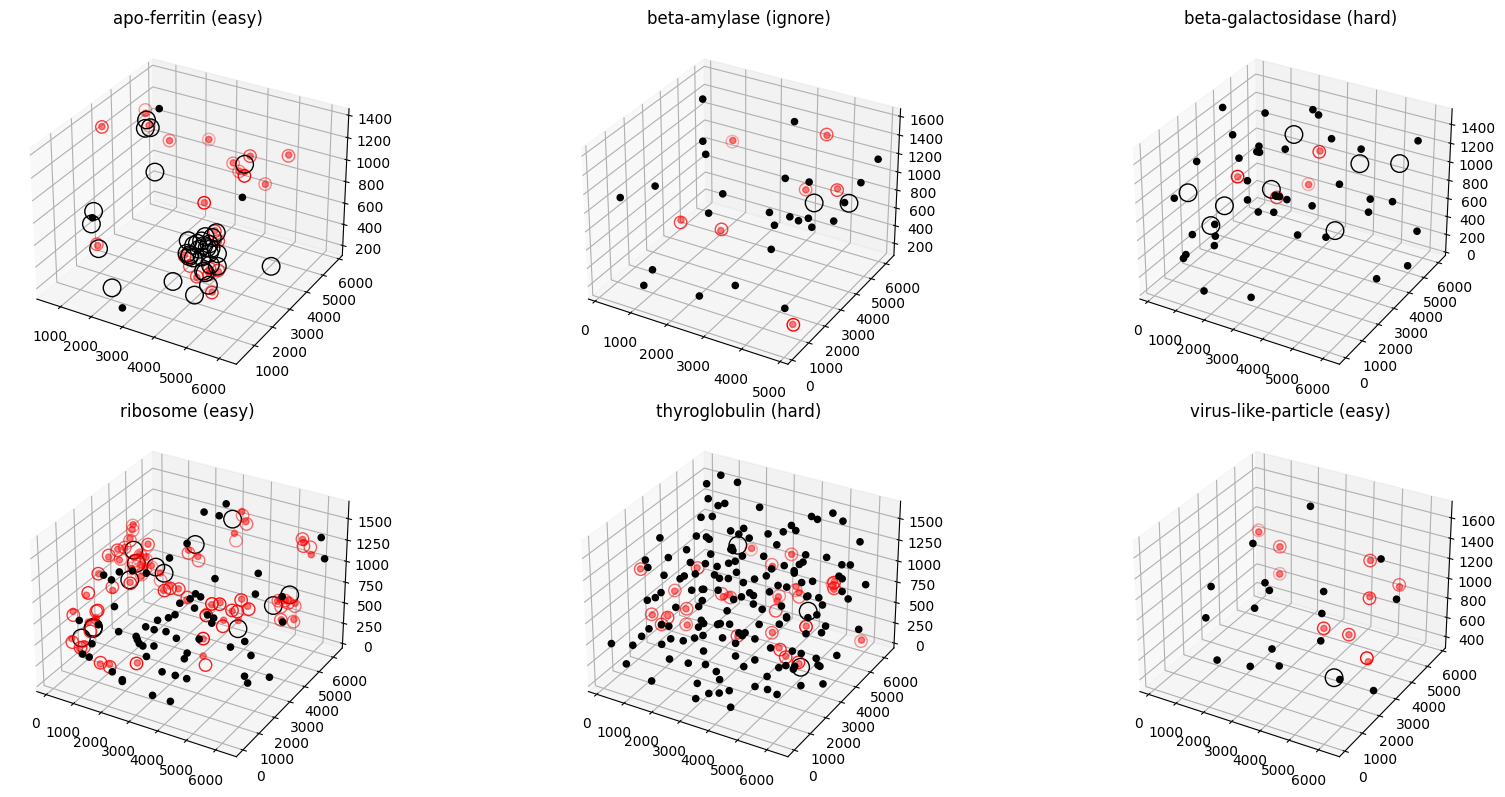

In [63]:
from czii_helper import *
from dataset import *
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt

import os
if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    MODE = 'submit'
else:
    MODE = 'local'







valid_dir ='/kaggle/input/czii-cryo-et-object-identification/train'
valid_id = ['TS_6_4', ]

def do_one_eval(truth, predict, threshold):
    P=len(predict)
    T=len(truth)

    if P==0:
        hit=[[],[]]
        miss=np.arange(T).tolist()
        fp=[]
        metric = [P,T,len(hit[0]),len(miss),len(fp)]
        return hit, fp, miss, metric

    if T==0:
        hit=[[],[]]
        fp=np.arange(P).tolist()
        miss=[]
        metric = [P,T,len(hit[0]),len(miss),len(fp)]
        return hit, fp, miss, metric

    #---
    distance = predict.reshape(P,1,3)-truth.reshape(1,T,3)
    distance = distance**2
    distance = distance.sum(axis=2)
    distance = np.sqrt(distance)
    p_index, t_index = linear_sum_assignment(distance)

    valid = distance[p_index, t_index] <= threshold
    p_index = p_index[valid]
    t_index = t_index[valid]
    hit = [p_index.tolist(), t_index.tolist()]
    miss = np.arange(T)
    miss = miss[~np.isin(miss,t_index)].tolist()
    fp = np.arange(P)
    fp = fp[~np.isin(fp,p_index)].tolist()

    metric = [P,T,len(hit[0]),len(miss),len(fp)] #for lb metric F-beta copmutation
    return hit, fp, miss, metric


def compute_lb(submit_df, overlay_dir):
    valid_id = list(submit_df['experiment'].unique())
    print(valid_id)

    eval_df = []
    for id in valid_id:
        truth = read_one_truth(id, overlay_dir) #=f'{valid_dir}/overlay/ExperimentRuns')
        id_df = submit_df[submit_df['experiment'] == id]
        for p in PARTICLE:
            p = dotdict(p)
            print('\r', id, p.name, end='', flush=True)
            xyz_truth = truth[p.name]
            xyz_predict = id_df[id_df['particle_type'] == p.name][['x', 'y', 'z']].values
            hit, fp, miss, metric = do_one_eval(xyz_truth, xyz_predict, p.radius* 0.5)
            eval_df.append(dotdict(
                id=id, particle_type=p.name,
                P=metric[0], T=metric[1], hit=metric[2], miss=metric[3], fp=metric[4],
            ))
    print('')
    eval_df = pd.DataFrame(eval_df)
    gb = eval_df.groupby('particle_type').agg('sum').drop(columns=['id'])
    gb.loc[:, 'precision'] = gb['hit'] / gb['P']
    gb.loc[:, 'precision'] = gb['precision'].fillna(0)
    gb.loc[:, 'recall'] = gb['hit'] / gb['T']
    gb.loc[:, 'recall'] = gb['recall'].fillna(0)
    gb.loc[:, 'f-beta4'] = 17 * gb['precision'] * gb['recall'] / (16 * gb['precision'] + gb['recall'])
    gb.loc[:, 'f-beta4'] = gb['f-beta4'].fillna(0)

    gb = gb.sort_values('particle_type').reset_index(drop=False)
    # https://www.kaggle.com/competitions/czii-cryo-et-object-identification/discussion/544895
    gb.loc[:, 'weight'] = [1, 0, 2, 1, 2, 1]
    lb_score = (gb['f-beta4'] * gb['weight']).sum() / gb['weight'].sum()
    return gb, lb_score


#debug
if 1:
    if MODE=='local':
    #if 1:
        submit_df=pd.read_csv(
           'submission.csv'
            # '/kaggle/input/hengck-czii-cryo-et-weights-01/submission.csv'
        )
        gb, lb_score = compute_lb(submit_df, f'{valid_dir}/overlay/ExperimentRuns')
        print(gb)
        print('lb_score:',lb_score)
        print('')


        #show one ----------------------------------
        fig = plt.figure(figsize=(18, 8))

        id = valid_id[0]
        truth = read_one_truth(id,overlay_dir=f'{valid_dir}/overlay/ExperimentRuns')

        submit_df = submit_df[submit_df['experiment']==id]
        for p in PARTICLE:
            p = dotdict(p)
            xyz_truth = truth[p.name]
            xyz_predict = submit_df[submit_df['particle_type']==p.name][['x','y','z']].values
            hit, fp, miss, _ = do_one_eval(xyz_truth, xyz_predict, p.radius)
            print(id, p.name)
            print('\t num truth   :',len(xyz_truth) )
            print('\t num predict :',len(xyz_predict) )
            print('\t num hit  :',len(hit[0]) )
            print('\t num fp   :',len(fp) )
            print('\t num miss :',len(miss) )

            ax = fig.add_subplot(2, 3, p.label, projection='3d')
            if hit[0]:
                pt = xyz_predict[hit[0]]
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], alpha=0.5, color='r')
                pt = xyz_truth[hit[1]]
                ax.scatter(pt[:,0], pt[:,1], pt[:,2], s=80, facecolors='none', edgecolors='r')
            if fp:
                pt = xyz_predict[fp]
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], alpha=1, color='k')
            if miss:
                pt = xyz_truth[miss]
                ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], s=160, alpha=1, facecolors='none', edgecolors='k')

            ax.set_title(f'{p.name} ({p.difficulty})')

        plt.tight_layout()
        plt.show()
        
        #--- 
        zz=0

In [64]:
location_df.head()

,id,experiment,particle_type,x,y,z
0,0,TS_5_4,apo-ferritin,5826.941927,5116.208644,92.172435
1,1,TS_5_4,apo-ferritin,2805.776682,1636.021518,202.452505
2,2,TS_5_4,apo-ferritin,2627.037478,2302.322527,245.774524
3,3,TS_5_4,apo-ferritin,2500.083522,2202.737680,304.667194
4,4,TS_5_4,apo-ferritin,616.906430,4274.908673,492.431874


In [65]:
location_df.to_csv("/kaggle/working/asciitree-0.3.3/submission.csv", index=False)

In [ ]:
"""
Derived from:
https://github.com/cellcanvas/album-catalog/blob/main/solutions/copick/compare-picks/solution.py
"""

import numpy as np
import pandas as pd

from scipy.spatial import KDTree


class ParticipantVisibleError(Exception):
    pass


def compute_metrics(reference_points, reference_radius, candidate_points):
    num_reference_particles = len(reference_points)
    num_candidate_particles = len(candidate_points)

    if len(reference_points) == 0:
        return 0, num_candidate_particles, 0

    if len(candidate_points) == 0:
        return 0, 0, num_reference_particles

    ref_tree = KDTree(reference_points)
    candidate_tree = KDTree(candidate_points)
    raw_matches = candidate_tree.query_ball_tree(ref_tree, r=reference_radius)
    matches_within_threshold = []
    for match in raw_matches:
        matches_within_threshold.extend(match)
    # Prevent submitting multiple matches per particle.
    # This won't be be strictly correct in the (extremely rare) case where true particles
    # are very close to each other.
    matches_within_threshold = set(matches_within_threshold)
    tp = int(len(matches_within_threshold))
    fp = int(num_candidate_particles - tp)
    fn = int(num_reference_particles - tp)
    return tp, fp, fn


def score(
        solution: pd.DataFrame,
        submission: pd.DataFrame,
        row_id_column_name: str,
        distance_multiplier: float,
        beta: int) -> float:
    '''
    F_beta
      - a true positive occurs when
         - (a) the predicted location is within a threshold of the particle radius, and
         - (b) the correct `particle_type` is specified
      - raw results (TP, FP, FN) are aggregated across all experiments for each particle type
      - f_beta is calculated for each particle type
      - individual f_beta scores are weighted by particle type for final score
    '''

    particle_radius = {
        'apo-ferritin': 60,
        'beta-amylase': 65,
        'beta-galactosidase': 90,
        'ribosome': 150,
        'thyroglobulin': 130,
        'virus-like-particle': 135,
    }

    weights = {
        'apo-ferritin': 1,
        'beta-amylase': 0,
        'beta-galactosidase': 2,
        'ribosome': 1,
        'thyroglobulin': 2,
        'virus-like-particle': 1,
    }

    particle_radius = {k: v * distance_multiplier for k, v in particle_radius.items()}

    # Filter submission to only contain experiments found in the solution split
    split_experiments = set(solution['experiment'].unique())
    submission = submission.loc[submission['experiment'].isin(split_experiments)]

    # Only allow known particle types
    if not set(submission['particle_type'].unique()).issubset(set(weights.keys())):
        raise ParticipantVisibleError('Unrecognized `particle_type`.')

    assert solution.duplicated(subset=['experiment', 'x', 'y', 'z']).sum() == 0
    assert particle_radius.keys() == weights.keys()

    results = {}
    for particle_type in solution['particle_type'].unique():
        results[particle_type] = {
            'total_tp': 0,
            'total_fp': 0,
            'total_fn': 0,
        }

    for experiment in split_experiments:
        for particle_type in solution['particle_type'].unique():
            reference_radius = particle_radius[particle_type]
            select = (solution['experiment'] == experiment) & (solution['particle_type'] == particle_type)
            reference_points = solution.loc[select, ['x', 'y', 'z']].values

            select = (submission['experiment'] == experiment) & (submission['particle_type'] == particle_type)
            candidate_points = submission.loc[select, ['x', 'y', 'z']].values

            if len(reference_points) == 0:
                reference_points = np.array([])
                reference_radius = 1

            if len(candidate_points) == 0:
                candidate_points = np.array([])

            tp, fp, fn = compute_metrics(reference_points, reference_radius, candidate_points)

            results[particle_type]['total_tp'] += tp
            results[particle_type]['total_fp'] += fp
            results[particle_type]['total_fn'] += fn

    aggregate_fbeta = 0.0
    for particle_type, totals in results.items():
        tp = totals['total_tp']
        fp = totals['total_fp']
        fn = totals['total_fn']

        precision = tp / (tp + fp) if tp + fp > 0 else 0
        recall = tp / (tp + fn) if tp + fn > 0 else 0
        fbeta = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall) if (precision + recall) > 0 else 0.0
        aggregate_fbeta += fbeta * weights.get(particle_type, 1.0)

    if weights:
        aggregate_fbeta = aggregate_fbeta / sum(weights.values())
    else:
        aggregate_fbeta = aggregate_fbeta / len(results)
    return aggregate_fbeta